## <center>  Chest X-rays Detection

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import glob
import os

In [2]:
os.environ["KERAS_BACKEND"] = "tensorflow"

### 1) Download kaggle files

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:44<00:00, 23.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


We get the folder structure with the code:
```
tree -L 3 path
```

Which gives the following structure:
```
Path
└── chest_xray
    ├── chest_xray
    │   ├── test
    │   ├── train
    │   └── val
    ├── __MACOSX
    │   └── chest_xray
    ├── test
    │   ├── NORMAL
    │   └── PNEUMONIA
    ├── train
    │   ├── NORMAL
    │   └── PNEUMONIA
    └── val
        ├── NORMAL
        └── PNEUMONIA
```
Files in the NORMAL and PNEUMONIA folders are all of ".jpg" extension.

### 2) Verify the data

Using the kaggle datasets, you can usually assume the dataset will be of quality, however it's still important to know your data and verify what it looks like.

Let's check that !

In [4]:
# Get the paths for the train, test and val folders
chest_xray_path = path + "/chest_xray"
test_path = chest_xray_path + "/test"
train_path = chest_xray_path + "/train"
val_path = chest_xray_path + "/val"

In [120]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib

# Get the Normal and Pneumonia path from a  parent folder
def normal_n_pneumonia_paths(parent_folder_path):
    return (parent_folder_path + "/NORMAL"), ( parent_folder_path + "/PNEUMONIA")

# Return random images paths from the folder given
def select_random_images_from_folder(path_folder, number_images):

    list_images_path = glob.glob(os.path.join(path_folder, "**", "*.jpeg"))

    print(f'Number of images in test folder = {len(list_images_path)} Should be 624')

    array_numbers_len_list = np.arange(0, len(list_images_path))

    # Select number_images numbers from the list
    list_random_numbers = np.random.choice(array_numbers_len_list, number_images)

    print(f'Indices selected = {list_random_numbers} between 0 and 624')

    return [list_images_path[i] for i in list_random_numbers]

# Print images from their path
def print_images_from_path(array_dim1_images_path):
    num_images = len(array_dim1_images_path)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

    if num_images == 1:  # Handle single image case
        axes = [axes]

    for ax, image_path in zip(axes, array_dim1_images_path):
        img = matplotlib.image.imread(image_path)  # Read image correctly
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Hide axes

    plt.show()

# Select random images from the folder and display them
def select_n_display_images_from_folder(path_folder, number_images):
    list_random_images_paths = select_random_images_from_folder(path_folder, number_images)
    print_images_from_path(list_random_images_paths)
    return list_random_images_paths


/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL


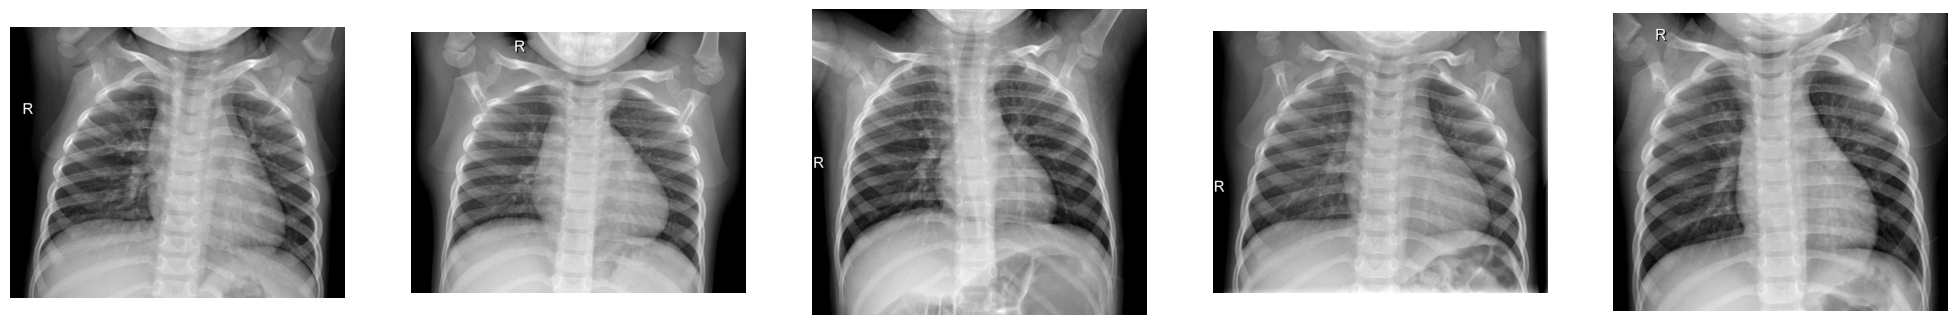

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0433-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0392-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0539-0001-0002.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1300-0001.jpeg']


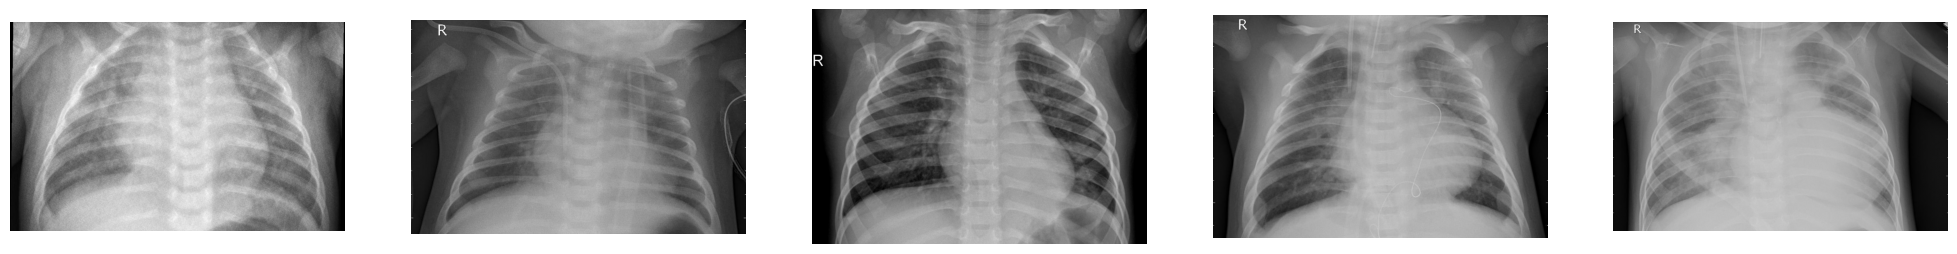

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person339_bacteria_1574.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person711_virus_1309.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person287_virus_586.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person761_bacteria_2665.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1020_bacteria_2951.jpeg']


In [6]:
num_images_to_display = 5

train_normal_path, train_pneumonia_path = normal_n_pneumonia_paths(train_path)
print(train_normal_path)

list_random_images_paths_normal = select_n_display_images_from_folder(train_normal_path, num_images_to_display)
print(list_random_images_paths_normal)

list_random_images_paths_pneumonia = select_n_display_images_from_folder(train_pneumonia_path, num_images_to_display)
print(list_random_images_paths_pneumonia)


### 3) Standardise the data

The data needs to have the same shape, rescaling pixel value to [0,1]

#### Reshape

In [7]:
from PIL import Image
from collections import defaultdict

# Verify the shapes existing

def count_num_images_shapes(folder_path):
    # Dictionary to count occurrences of each unique shape
    shape_counts = defaultdict(int)

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                shape = img.size  # (width, height)
                shape_counts[shape] += 1  # Count occurrences of each shape

    # Print unique shapes and their counts
    #for shape, count in shape_counts.items():
    #    print(f"Shape {shape}: {count} images")
    nb_shapes = 10
    if len(shape_counts.items()) > nb_shapes:
      print(f"There are more than {nb_shapes} different shapes in this dictionary.")

    return shape_counts

In [8]:
dictionary_shapes = count_num_images_shapes(train_normal_path)

There are more than 10 different shapes in this dictionary.


All the shapes are different, let's try ro find a shape that would work on all images, starting with the minimum shape (both width and height).

In [9]:
list_shapes = list(dictionary_shapes.keys())

# Get the min width and heigth
min_width, min_height = list(map(min, zip(*list_shapes)))
print(f"Min width: {min_width} \nMin height: {min_height}")

Min width: 912 
Min height: 672


We like powers of 2 for shapes as it works very well with maximisation of physical space, pooling steps, etc.

Let's reshape our images to (224, 224) wich is the value most pre-trained models have been trained on. Also the lower values for the width and height are to avoid using padding on images.

All images seem to have been resized without any issues, let's start loading the whole dataset for training.

In [10]:
import os

def count_files_and_classes(folder_path):
    """
    Count the number of files and classes in a folder where each subfolder represents a class.

    Args:
        folder_path (str): Path to the root folder containing subfolders of images.

    Returns:
        dict: A dictionary with class names as keys and the number of images as values.
        int: Total number of images.
        int: Total number of classes.
    """
    # Get the list of subfolders (classes)
    class_names = sorted(os.listdir(folder_path))
    num_classes = len(class_names)

    # Count the number of files in each class
    class_counts = {}
    total_files = 0

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            num_files = len(os.listdir(class_folder))
            class_counts[class_name] = num_files
            total_files += num_files

    return class_counts, total_files, num_classes

# Check the training dataset
class_counts, total_files, num_classes = count_files_and_classes(train_path)

# Print the results
print("Training class counts:", class_counts)
print("Training total number of files:", total_files)
print("Training total number of classes:", num_classes)

Training class counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Training total number of files: 5216
Training total number of classes: 2


In [11]:
# Check the Validation dataset
class_counts, total_files, num_classes = count_files_and_classes(val_path)

# Print the results
print("Validation class counts:", class_counts)
print("Validation total number of files:", total_files)
print("Validation total number of classes:", num_classes)

Validation class counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Validation total number of files: 16
Validation total number of classes: 2


Sometimes even having a great database is not enough. I will use data augmentation to diversify the datasets.

In [18]:
def directory_path_to_keras_dataset(directory_path, target_size, batch_size):

    # create the dataset with keras directly from the directory
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  directory_path,
                  image_size=target_size,
                  label_mode="binary",  # Use "binary" for binary classification
                  batch_size=batch_size,
                  color_mode="grayscale",  # Convert images to grayscale
                  shuffle=True,
                  seed=42,
                  )

    # Data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ])

    # Apply data augmentation
    augmented_dataset = dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y))

    # Cobine both original and augmented dataset
    combined_dataset = dataset.concatenate(augmented_dataset)

    # Configure for performance and ease the memory usage
    combined_dataset = combined_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return combined_dataset

Load the datasets

In [14]:
# Define image size
width = 224
height = 224
target_size = (width, height)  # Desired shape
batch_size = 64

In [19]:
import tensorflow as tf
# Create training dataset
train_dataset = directory_path_to_keras_dataset(train_path, target_size, batch_size)

# Create validation dataset
val_dataset = directory_path_to_keras_dataset(val_path, target_size, batch_size)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [20]:
# Inspect the first batch of the training dataset
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, width, height, 1) the last number is of dimension one because of b&w image
    print("Labels shape:", labels.shape)  # Should be (batch_size,)

Images shape: (64, 224, 224, 1)
Labels shape: (64, 1)


In [21]:
# Inspect the first batch of the validation dataset
for images, labels in val_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, width, height, 1) the last number is of dimension one because of b&w image
    print("Labels shape:", labels.shape)  # Should be (batch_size,)

Images shape: (16, 224, 224, 1)
Labels shape: (16, 1)


### 4) Creation of model

Manual model

A random manual model to compare the pre-trained one with

In [22]:
import keras
from keras import layers

def basic_CNN_model(input_shape, nb_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Conv2D(128, 3, strides=2, padding="same")(inputs) # Picture of shape (256,256) after
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x) # It's 256 because the shape of the image at that stage is (256,256)
    outputs = layers.Dense(nb_classes , activation="sigmoid")(x) # We return the probability of belinging to a certain class
    return keras.Model(inputs, outputs)

In [23]:
input_shape = (width, height, 1)  # Desired shape
nb_classes = 1

model = basic_CNN_model(input_shape,nb_classes)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 112, 112, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1605632)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     205,521,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,522,945 (784.01 MB)

 Trainable params: 205,522,689 (784.01 MB)

 Non-trainable params: 256 (1.00 KB)

Pre-trained model

In [24]:
import keras_hub

image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_vd_50_ssld_v2_fix_imagenet",
    activation="sigmoid",
    num_classes=nb_classes,
)

image_classifier.summary()

100%|██████████| 908/908 [00:00<00:00, 1.73MB/s]


100%|██████████| 3.69k/3.69k [00:00<00:00, 7.56MB/s]


100%|██████████| 98.2M/98.2M [00:07<00:00, 13.9MB/s]


100%|██████████| 90.4M/90.4M [00:07<00:00, 13.2MB/s]


Preprocessor: "res_net_image_classifier_preprocessor_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ res_net_image_converter_5 (ResNetImageConverter)              │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "res_net_image_classifier_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)                    │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone_5 (ResNetBackbone)           │ (None, None, None, 2048)           │          23,580,512 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 1)                          │               2,049 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 23,582,561 (89.96 MB)

 Trainable params: 23,529,313 (89.76 MB)

 Non-trainable params: 53,248 (208.00 KB)

### 5) Training

Manual model

In [25]:
# Variables used in the training section
epochs = 15

In [26]:
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(name="acc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")],
)

best_manual_model_path = "best_manual_model.keras"
best_manual_model_training_history_path = 'training_history_best_manual_model.pkl'

callbacks = [
    keras.callbacks.ModelCheckpoint(best_manual_model_path, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
]

In [27]:
#if os.path.exists(best_manual_model_path) and os.path.exists(best_manual_model_training_history_path):
#    model = keras.models.load_model(best_manual_model_path)
#        # Load the history
#    with open(best_manual_model_training_history_path, 'rb') as file:
#        history_manual_model = pickle.load(file)
#
#else:
history_manual_model = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_dataset,
    verbose=1
)
    # Save the history
#    with open('training_history_best_manual_model.pkl', 'wb') as file:
#        pickle.dump(history_manual_model.history, file)

Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 44s 233ms/step - acc: 0.8543 - loss: 36.0730 - precision: 0.9020 - recall: 0.8998 - val_acc: 0.6250 - val_loss: 54.9277 - val_precision: 0.7500 - val_recall: 0.3750
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - acc: 0.9123 - loss: 8.0088 - precision: 0.9440 - recall: 0.9368 - val_acc: 0.6875 - val_loss: 14.3684 - val_precision: 0.6875 - val_recall: 0.6875
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - acc: 0.9450 - loss: 4.1635 - precision: 0.9606 - recall: 0.9653 - val_acc: 0.6250 - val_loss: 21.0379 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - acc: 0.9580 - loss: 0.9152 - precision: 0.9701 - recall: 0.9732 - val_acc: 0.6875 - val_loss: 0.8211 - val_precision: 0.6364 - val_recall: 0.8750
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 27s 166ms/step - acc: 0.9690 - loss: 0.0911 - precision: 0.9786 - recall: 0.9795 - val_acc: 0.7500 - val_loss: 1.0334 - val_precision: 0.6667 - 

In [28]:
# Access history data
print(history_manual_model.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history_manual_model.history['loss'])  # Prints loss values per epoch
print(history_manual_model.history['acc'])  # Prints accuracy values per epoch
print(history_manual_model.history['precision'])  # Prints Precision values per epoch
print(history_manual_model.history['recall'])  # Prints Recall values per epoch

dict_keys(['acc', 'loss', 'precision', 'recall', 'val_acc', 'val_loss', 'val_precision', 'val_recall'])
[19.97617530822754, 9.001806259155273, 6.434895992279053, 1.2722012996673584, 0.15680919587612152, 0.1353275030851364, 0.11981511116027832, 0.12023705989122391, 0.11932295560836792, 0.13098908960819244, 0.13192753493785858, 0.10987858474254608, 0.12141313403844833, 0.13280050456523895, 0.12633490562438965]
[0.8672354221343994, 0.8962806463241577, 0.9109470844268799, 0.9263803958892822, 0.941717803478241, 0.9500575065612793, 0.9544669985771179, 0.9553297758102417, 0.9560007452964783, 0.9502492547035217, 0.9503450989723206, 0.9570552110671997, 0.9529333114624023, 0.9488113522529602, 0.9516870975494385]
[0.9116543531417847, 0.9316416382789612, 0.940007746219635, 0.9489454627037048, 0.9623252153396606, 0.9616809487342834, 0.9685688614845276, 0.9701781272888184, 0.9697204232215881, 0.9648965001106262, 0.9677878618240356, 0.9703684449195862, 0.9672975540161133, 0.9656685590744019, 0.968208

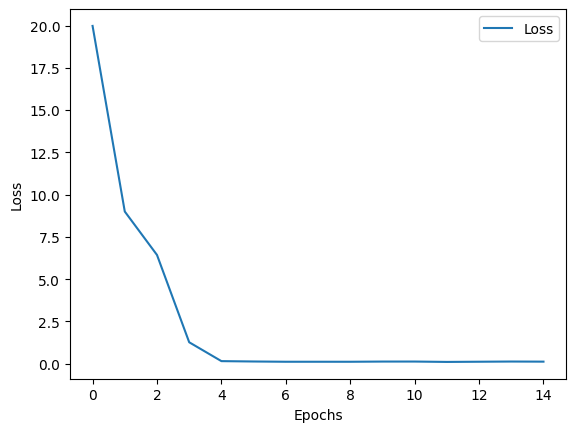

In [29]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history_manual_model.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Pre-trained Model

In [30]:
image_classifier.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(name="acc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")],
)

best_pretrained_model_path = "best_pretrained_model.keras"

image_classifier_callbacks = [
    keras.callbacks.ModelCheckpoint(best_pretrained_model_path, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
]

In [31]:
history_image_classifier = image_classifier.fit(
        train_dataset,
        epochs=epochs,
        callbacks=image_classifier_callbacks,
        validation_data=val_dataset,
        verbose=1
    )

Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 317ms/step - acc: 0.9252 - loss: 0.1843 - precision: 0.9567 - recall: 0.9405 - val_acc: 0.5625 - val_loss: 1.5894 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - acc: 0.9692 - loss: 0.0848 - precision: 0.9776 - recall: 0.9808 - val_acc: 0.7188 - val_loss: 0.5373 - val_precision: 0.6400 - val_recall: 1.0000
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - acc: 0.9752 - loss: 0.0662 - precision: 0.9821 - recall: 0.9843 - val_acc: 0.8125 - val_loss: 0.5135 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 33s 197ms/step - acc: 0.9837 - loss: 0.0478 - precision: 0.9903 - recall: 0.9877 - val_acc: 0.9062 - val_loss: 0.1923 - val_precision: 0.8824 - val_recall: 0.9375
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 31s 187ms/step - acc: 0.9798 - loss: 0.0486 - precision: 0.9875 - recall: 0.9853 - val_acc: 0.9062 - val_loss: 0.2481 - val_precision: 0.8421 - val

In [32]:
# Access history data
print(history_image_classifier.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history_image_classifier.history['loss'])  # Prints loss values per epoch
print(history_image_classifier.history['acc'])  # Prints accuracy values per epoch
print(history_image_classifier.history['precision'])  # Prints Precision values per epoch
print(history_image_classifier.history['recall'])  # Prints Recall values per epoch

dict_keys(['acc', 'loss', 'precision', 'recall', 'val_acc', 'val_loss', 'val_precision', 'val_recall'])
[0.16795231401920319, 0.11234311759471893, 0.09149238467216492, 0.07537003606557846, 0.07613655179738998, 0.07116232067346573, 0.06125853955745697, 0.06246551126241684, 0.04992325231432915, 0.054184164851903915, 0.05095767229795456, 0.04473753646016121]
[0.933282196521759, 0.9575344920158386, 0.9652032256126404, 0.9726802110671997, 0.9685583114624023, 0.973351240158081, 0.9772814512252808, 0.9769938588142395, 0.9820743799209595, 0.9803489446640015, 0.9820743799209595, 0.9836081266403198]
[0.9582900404930115, 0.9709939360618591, 0.978246808052063, 0.9821728467941284, 0.9788386821746826, 0.9820645451545715, 0.9841474294662476, 0.9851421117782593, 0.9883766174316406, 0.9873401522636414, 0.9890081286430359, 0.9892833828926086]
[0.9516128897666931, 0.9718709588050842, 0.9748387336730957, 0.9810322523117065, 0.9788386821746826, 0.9820645451545715, 0.9852903485298157, 0.9838709831237793, 0.

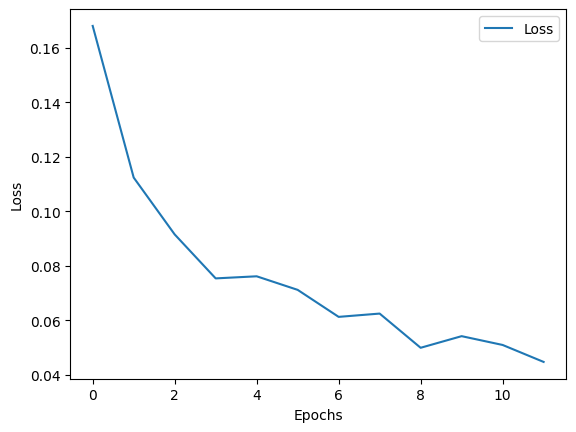

In [33]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history_image_classifier.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 6) Evaluation

In [34]:
# Load test dataset
test_dataset = directory_path_to_keras_dataset(test_path, target_size, batch_size)

Found 624 files belonging to 2 classes.


Manual_model

In [35]:
score_manual_model = model.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - acc: 0.7822 - loss: 0.8146 - precision: 0.7488 - recall: 0.9875


In [36]:
# Print the evaluation results
print(f"Test Loss: {score_manual_model[0]}")
print(f"Test Accuracy: {score_manual_model[1]}")
print(f"Test Precision: {score_manual_model[2]}")
print(f"Test Recall: {score_manual_model[2]}")

f1_score_manual_model = 2 * (score_manual_model[2] * score_manual_model[3]) / (score_manual_model[2] + score_manual_model[3])
print(f"Test F1 Score: {f1_score_manual_model}")

Test Loss: 0.8627704977989197
Test Accuracy: 0.7556089758872986
Test Precision: 0.7213420271873474
Test Recall: 0.7213420271873474
Test F1 Score: 0.8354020373122264


Pre_trained model

In [37]:
score_pretrained_model = image_classifier.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - acc: 0.8652 - loss: 0.3522 - precision: 0.8273 - recall: 0.9903


In [38]:
# Print the evaluation results
print(f"Test Loss: {score_pretrained_model[0]}")
print(f"Test Accuracy: {score_pretrained_model[1]}")
print(f"Test Precision: {score_pretrained_model[2]}")
print(f"Test Recall: {score_pretrained_model[2]}")

f1_score_pretrained_model = 2 * (score_pretrained_model[2] * score_pretrained_model[3]) / (score_pretrained_model[2] + score_pretrained_model[3])
print(f"Test F1 Score: {f1_score_pretrained_model}")

Test Loss: 0.44588708877563477
Test Accuracy: 0.8461538553237915
Test Precision: 0.8068893551826477
Test Recall: 0.8068893551826477
Test F1 Score: 0.8895281889752135


### 7) Application

In [39]:
import cv2
from scipy.ndimage import zoom
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

As seen in the resnet_50 model summary we have a pooling and a prediction layer for the transfer learning, we're going to use them to display the heatmap over the image.

In [42]:
from tensorflow.keras.models import Model

# Get the output layers that we want from the model
conv_output = image_classifier.get_layer("res_net_backbone_5").output
pred_ouptut = image_classifier.get_layer("predictions").output

# Create the same model to have 2 outputs (pooling, predictions) instead of only predictions
applied_image_classifier = Model(image_classifier.input, outputs=[conv_output, pred_ouptut])

In [127]:
# Number of images to display
N = 6

In [128]:
# Select randomly pictures
random_image_path = select_random_images_from_folder(test_path, N) # Get the first and only element from the list

# Load the image and resize it from it's path
def load_and_resize_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    return img

list_imgs = [load_and_resize_image(path, target_size) for path in random_image_path]

# Expands the dimensions to fit it to the input shape of the model
X = tf.convert_to_tensor(list_imgs)
print(X.shape)

# Get the results of the prediction on the picture
conv, pred = applied_image_classifier.predict(X)
print(f"Prediction classes: {pred}")
print(f"Shape convolution layer output : {conv.shape}")

Number of images in test folder = 624 Should be 624
Indices selected = [345  94 575 489 397 476] betweet 0 and 624
(6, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction classes: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Shape convolution layer output : (6, 7, 7, 2048)


In [113]:
def pred_to_text(pred):
    if pred > 0.5:
        return "PNEUMONIA"
    else:
        return "NORMAL"

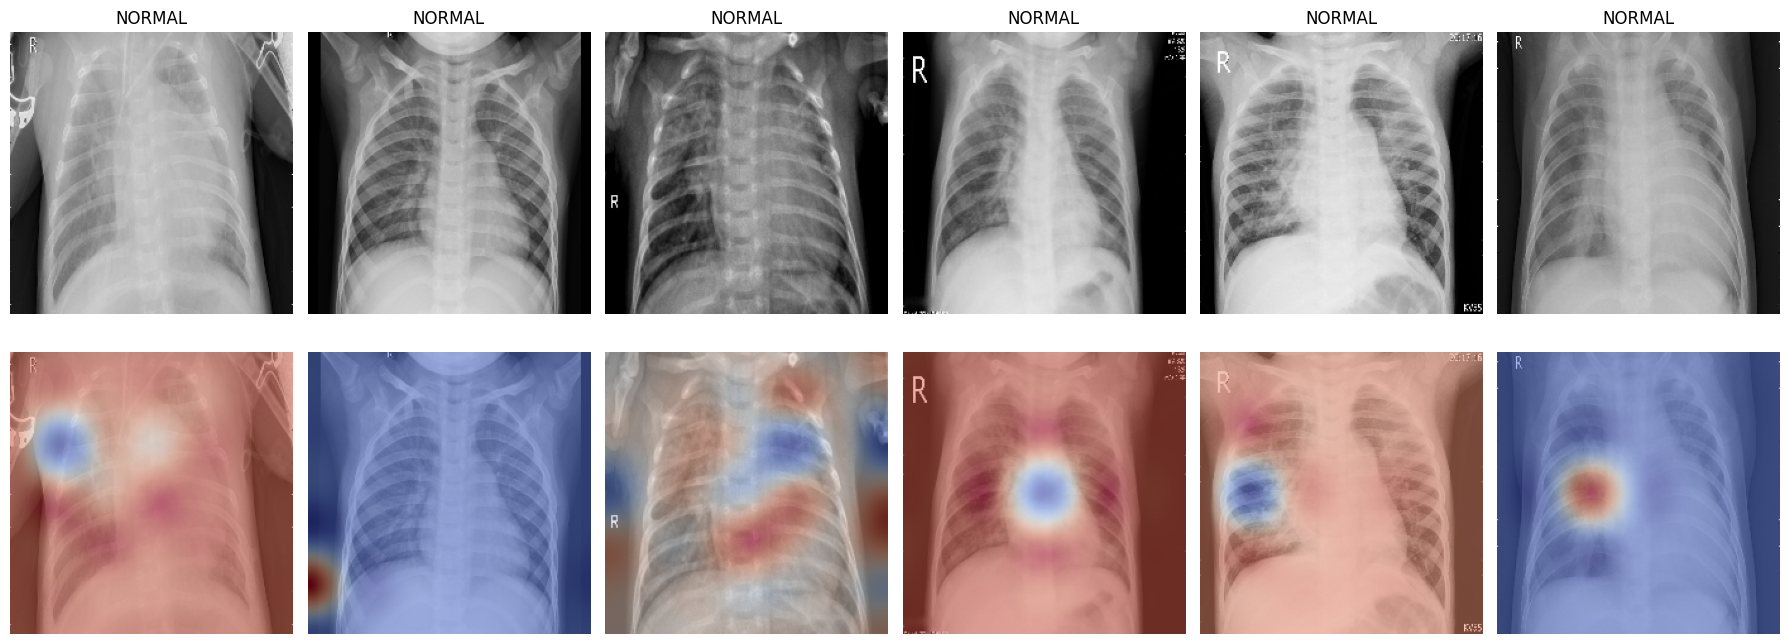

In [129]:
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Example scaling factor (adjust based on your model's output shape) here the last conv layer shape was (5, 7, 7, 2048) as seen 2 cells above
# We know the pictures are of shape (224, 224) the last conv layer of the pre-trained model gives a (_, 7, 7, _) image
# The scaling factor should be 224/7 : (width OR height) / (conv.shape[1] OR conv.shape[2])
scale = width / conv.shape[1]

# Create a figure with N subplots
plt.figure(figsize=(3*N, 7))  # Adjust the figure size as needed

for i in range(N):
    # Display the original image
    plt.subplot(2, N, i+1)
    plt.imshow(cv2.cvtColor(list_imgs[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')
    plt.title(pred_to_text(pred[i][0]))

    # Generate the heatmap
    heatmap = np.mean(conv[i], axis=-1)  # Average over the channels to get a 2D heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize

    # Apply the tangent function to exacerbate the interesting parts of the heatmap
    heatmap = np.tan(heatmap * 5)  # Scale the heatmap values before applying tan

    # Resize the heatmap to match the original image size
    scale = list_imgs[i].shape[0] / heatmap.shape[0]
    heatmap = zoom(heatmap, zoom=(scale, scale))

    # Display the heatmap over the original image
    plt.subplot(2, N, N + i + 1)
    plt.imshow(cv2.cvtColor(list_imgs[i], cv2.COLOR_BGR2RGB))
    plt.imshow(heatmap, cmap='coolwarm', alpha=0.5)  # Overlay the heatmap with transparency
    plt.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()